In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import sys
sys.path.append('../src')

from models.fc_scratch import FCNetworkScratch

print("✓ Imports successful")

✓ Imports successful


In [13]:
# Cell 2: Load data with environment detection
import os

# Auto-detect environment
if 'COLAB_GPU' in os.environ or os.path.exists('/content'):
    LOCAL_MODE = False
    print("🚀 Running on Google Colab")
else:
    LOCAL_MODE = True
    print("💻 Running locally")

# Load dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('../data/raw', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data/raw', train=False, download=True, transform=transform)

# Prepare data function
def prepare_data(dataset, num_samples=None):
    """Convert dataset to numpy arrays"""
    if num_samples is None:
        num_samples = len(dataset)

    X = np.zeros((784, num_samples))
    y = np.zeros((10, num_samples))

    for i in range(num_samples):
        image, label = dataset[i]
        X[:, i] = image.numpy().flatten()
        y[label, i] = 1

    return X, y

# Load appropriate amount based on environment
if LOCAL_MODE:
    print("Using small subset (1000 train, 200 test)")
    X_train, y_train = prepare_data(train_dataset, num_samples=6000)
    X_test, y_test = prepare_data(test_dataset, num_samples=1000)
else:
    print("Using full dataset (60000 train, 10000 test)")
    X_train, y_train = prepare_data(train_dataset)
    X_test, y_test = prepare_data(test_dataset)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

💻 Running locally
Using small subset (1000 train, 200 test)
X_train shape: (784, 6000)
X_test shape: (784, 1000)


In [14]:
# Cell 3: Initialize model
model = FCNetworkScratch(
    input_size=784,
    hidden_sizes=[128, 64],
    num_classes=10
)

print("Model architecture:")
print("  Input: 784 (28x28 flattened)")
print("  Hidden Layer 1: 128 neurons + ReLU")
print("  Hidden Layer 2: 64 neurons + ReLU")
print("  Output: 10 classes (digits 0-9)")

Model architecture:
  Input: 784 (28x28 flattened)
  Hidden Layer 1: 128 neurons + ReLU
  Hidden Layer 2: 64 neurons + ReLU
  Output: 10 classes (digits 0-9)


In [15]:
# Cell 4: Training functions
def train_epoch(model, X, y, batch_size=128, learning_rate=0.01):
    """Train for one epoch"""
    num_samples = X.shape[1]
    num_batches = num_samples // batch_size
    epoch_loss = 0

    # Shuffle data
    indices = np.random.permutation(num_samples)
    X_shuffled = X[:, indices]
    y_shuffled = y[:, indices]

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size

        X_batch = X_shuffled[:, start_idx:end_idx]
        y_batch = y_shuffled[:, start_idx:end_idx]

        loss = model.train_step(X_batch, y_batch, learning_rate)
        epoch_loss += loss

    return epoch_loss / num_batches

def evaluate(model, X, y):
    """Evaluate accuracy"""
    predictions = model.predict(X)
    true_labels = np.argmax(y, axis=0)
    accuracy = np.mean(predictions == true_labels)
    return accuracy

print("✓ Training functions defined")

✓ Training functions defined


In [16]:
# Cell 5: Train the model
num_epochs = 8 if LOCAL_MODE else 10
batch_size = 32 if LOCAL_MODE else 128
learning_rate = 0.1

train_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    loss = train_epoch(model, X_train, y_train, batch_size, learning_rate)
    train_losses.append(loss)


    train_acc = evaluate(model, X_train, y_train)
    test_acc = evaluate(model, X_test, y_test)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(epoch,train_acc, test_acc)

Starting training...
0 0.2663333333333333 0.239
1 0.4535 0.435
2 0.6403333333333333 0.614
3 0.7365 0.691
4 0.7786666666666666 0.738
5 0.805 0.766
6 0.8328333333333333 0.792
7 0.8431666666666666 0.797


In [17]:
# Cell 5: Train with better settings for your CPU
num_epochs = 5 if LOCAL_MODE else 10
batch_size = 64
learning_rate = 0.1

# Use more training data locally since your CPU can handle it
if LOCAL_MODE:
    print("Using 5000 train samples, 1000 test samples")
    X_train, y_train = prepare_data(train_dataset, num_samples=6000)
    X_test, y_test = prepare_data(test_dataset, num_samples=1000)

train_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    loss = train_epoch(model, X_train, y_train, batch_size, learning_rate)
    train_losses.append(loss)

    train_acc = evaluate(model, X_train, y_train)
    test_acc = evaluate(model, X_test, y_test)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Loss: {loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Test Acc: {test_acc*100:.2f}%")

print("=" * 60)
print(f"Final Test Accuracy: {test_accuracies[-1]*100:.2f}%")

Using 5000 train samples, 1000 test samples
Starting training...
Epoch 1/5 | Loss: 0.7907 | Train Acc: 84.70% | Test Acc: 80.50%
Epoch 2/5 | Loss: 0.7646 | Train Acc: 84.98% | Test Acc: 81.10%
Epoch 3/5 | Loss: 0.7401 | Train Acc: 85.20% | Test Acc: 81.20%
Epoch 4/5 | Loss: 0.7203 | Train Acc: 85.33% | Test Acc: 81.50%
Epoch 5/5 | Loss: 0.6993 | Train Acc: 85.55% | Test Acc: 82.00%
Final Test Accuracy: 82.00%


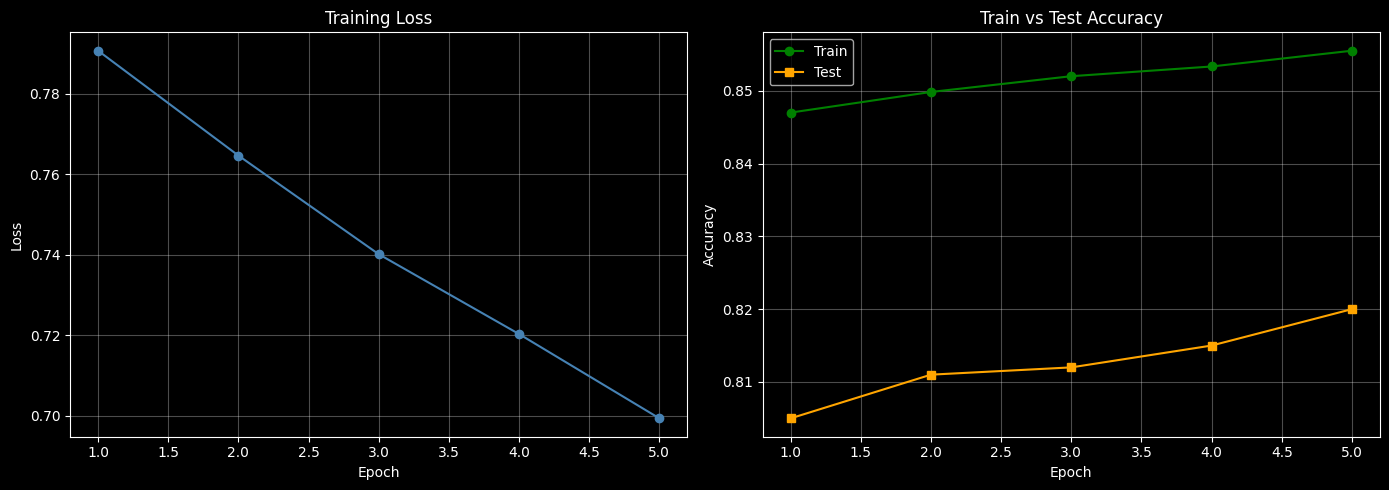

In [18]:
# Cell 6: Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, num_epochs + 1), train_losses, marker='o', color='steelblue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train', color='green')
ax2.plot(range(1, num_epochs + 1), test_accuracies, marker='s', label='Test', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train vs Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()